# Outline

This notebook complements the blog post and is intended to cover the following topics:
- Reproduce results/analysis, with code examples. This can be edited to score on your own data.
- Deep dive into results and errors from blog post.
- Misc discussion.

# Reproduce scoring results

## Setup


If you have cloned the repro and are running this locally, make sure you first follow setup in `tinydiarize/README.md`, particularly the section on the fstalign scoring tool. This notebook handles the rest of the setup (including downloading eval data).

> NOTE: If running on Google Colab - this notebook will fetch and use pre-computed results until we figure out how to get the fstalign scoring tool working on Colab.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython import get_ipython
from IPython import display as ipd

In [3]:
if 'google.colab' in str(get_ipython()):
    # clone a particular branch of tinydiarize repo
    ! git clone https://github.com/akashmjn/tinyDiarize.git -b analysis-1 --single-branch
    # pip install
    ! pip install -e tinyDiarize
    # setup workdir
    WORKDIR = 'tinyDiarize/tinydiarize/workdir_analysis'
    CODEDIR = 'tinyDiarize/tinydiarize'
    _PRE_COMPUTED = True
else:
    # if running locally, assume that tinydiarize repo is already cloned and installed
    WORKDIR = '../workdir_analysis'
    CODEDIR = '..'
    _PRE_COMPUTED = False

ipd.clear_output()

## Evaluation data

We are using an out-of-distribution setup, evaluating on a different dataset than what the model was finetuned on (AMI meetings). As in Whisper, this allows us to get a more realistic estimate of real-world generalization vs the model's ability to fit dataset-specific quirks of the AMI dataset.

For ease of analysis (and keeping with the 'tiny' spirit 😊), I've chosen a biased subset of 3 earnings calls from [rev/earnings21](https://github.com/revdotcom/speech-datasets/blob/main/earnings21/earnings21-file-metadata.csv). These were selected with the following criteria:
- One interactive Q&A meeting (*939, Hershey) with a higher number of speaker switches and unique speakers
- One meeting (*910, Amex) that is a moderated Q&A between only 2 speakers
- One meeting (*971, Constellium) that comprises both a presentation and Q&A session, and is somewhere in between

| file_id | audio_length | company_name | sector | speaker_switches | speaker_switches / minute | unique_speakers |
|---------|--------------|--------------|--------|------------------|---------------------------|-----------------|
| 4385939 | 3049.832     | Hershey Company | Consumer Goods | 132 | 2.60 | 19 |
| 4374910 | 2028.536     | American Express Company | Financial | 56 | 1.66 | 2 |
| 4359971 | 3759.944     | Constellium | Industrial Goods | 116 | 1.85 | 10 |

In [4]:
# setup workdir structure and fetch evaluation data
if _PRE_COMPUTED:
    # download pre-computed results from blob
    ! wget -O {CODEDIR}/workdir_analysis.tar.gz https://sharedstorage7190.blob.core.windows.net/tinydiarize/precomputed/workdir_analysis/5e09d4787a2674ea773547dcb9f23321a472bea883917337e0139a2ba0c2dd34.tar.gz
    # unpack pre-computed results into WORKDIR
    ! tar -xzf {CODEDIR}/workdir_analysis.tar.gz -C {CODEDIR}
else:
    ! mkdir -p {WORKDIR}
    # call a bash script with WORKDIR as an environment variable
    ! bash {CODEDIR}/scripts/fetch_earnings21_calls.sh {WORKDIR}

ipd.clear_output()

In [ ]:
# listen to an example file 
ipd.Audio(f'{WORKDIR}/audio/earnings21-4374910.mp3')

## Transcribing and scoring

We use a convenience script to transcribe and score the calls with various transcription pipelines (explained in the following sections). This script runs both ASR and diarization components, scores them and parses detailed results into a single tsv file (implemented in `score.py`).

> *NOTE: On Google colab, we will fetch pre-computed results from my runs, as it's a bit tricky to setup the fstalign scoring tool*

`TODO@Akash` - verify run_pipelines works, for now assuming that results are generated correctly

In [ ]:
if not _PRE_COMPUTED:
    # change directory to ../scripts
    ! cd {CODEDIR}/scripts

    # process all the selected calls
    calls = [
        ("earnings21-4385939", 19),
        ("earnings21-4374910", 2),
        ("earnings21-4359971", 10),
    ]

    # iterate over calls and run the script run_pipelines.py
    for call_id, num_speakers in calls:
        ! python run_pipelines.py {WORKDIR}/audio/{call_id}.mp3 {WORKDIR}/fstalign_scoring/references/{call_id}-ref.nlp {WORKDIR}/transcripts/tiny.en/{call_id} --num_speakers {num_speakers}

    # change directory back to ../notebooks
    ! cd ./notebooks


## Running on your own data 

To do so, you will need to:
- Replace files under `WORKDIR/audio` with your own audio files
- Create reference files in the [fstalign NLP format](https://github.com/revdotcom/fstalign/blob/develop/docs/NLP-Format.md]) under `WORKDIR/fstalign_scoring/references` 
- Make sure that the NLP contains speaker IDs in column 2. These are only used to score speaker turns. If your transcript only has speaker turns without global IDs, you can just increment a dummy speaker ID after every turn.

Once this is done, you can simply plug it in to the `run_pipelines.py` script as above.

# Deep dive into results and errors

## Information on metrics

Diarization typically uses either time-based metrics (e.g. DER measures % of time correctly attributed) or transcript-based metrics that compare the final transcript. 

I prefer to use the latter as:
- It helps us see errors the way an end-user would i.e. [WYSIWYG](https://en.wikipedia.org/wiki/WYSIWYG). 
- Tricky issues such as disfluencies, speaker overlap, etc. can be handled in an interpretable way via the transcription convention (e.g. using special tokens for disfluencies, speaker overlap, and/or text normalization).
- Analyzing errors in the semantic context of the conversation is much more intuitive than looking at time-based metrics, and helps us quickly get a sense of where we need to focus.

For our analysis here, we only score the "local" diarization sub-task of speaker segmentation (not the "global" task of clustering speakers across the entire meeting). We use the following metrics:
- WER: word error rate as measured by `fstalign`
- Speaker turn recall: the fraction of speaker changes that are correctly identified
- Speaker turn precision: the fraction of predicted speaker changes that are correct

Just like WER, speaker turn recall and precision are computed by aligning reference and hypothesis transcripts, after inserting a special `speaker__turn` token, and then counting errors on the special tokens. This is done via `fstalign` as well.

## Compiling results

We now compile all the TSV files generated by `run_pipelines.py` into a single dataframe for analysis. 

In [40]:
# some utility functions
%load_ext autoreload
%autoreload 2
import sys
sys.path.append(CODEDIR)
from analysis_utils import compile_results, query_metric_results, plot_metric_results, inspect_errors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The dataframe contains a detailed error breakdown of each metric e.g. (DEL/INS/SUB) for WER, false positives (INS/SUB) and false negatives (DEL/SUB) for speaker turn recall and precision. 

We also parse the fstalign `*.sbs` alignment output to get the exact errors made by the model. This is useful for debugging and understanding the model's behavior.

In [43]:
results_df, analysis_results = compile_results(f"{WORKDIR}/fstalign_scoring/results")
results_df.head()

Read 84 results from 21 files
Read 21 side-by-side analysis results


,metric,value,denominator,numerator,deletions,insertions,substitutions,result_id,model,call_id,method
0,wer_overall,7.498897,9068,680,83,228,369,small.en-ft_decoder-frz_bpe_time_2-hp2.pt__ear...,small.en-ft,4385939,tdrz_token
1,wer_speaker_switch,11.422846,998,114,27,31,56,small.en-ft_decoder-frz_bpe_time_2-hp2.pt__ear...,small.en-ft,4385939,tdrz_token
2,spk_turn_precision,98.958328,96,95,0,1,0,small.en-ft_decoder-frz_bpe_time_2-hp2.pt__ear...,small.en-ft,4385939,tdrz_token
3,spk_turn_recall,72.519081,131,95,30,0,6,small.en-ft_decoder-frz_bpe_time_2-hp2.pt__ear...,small.en-ft,4385939,tdrz_token
0,wer_overall,13.713123,4915,674,360,71,243,small.en__earnings21-4374910_drz_pre_sr__segment,small.en,4374910,pyannote_pre_sr


We compare speaker turn recall/precision for the following pipelines that were run above:
- `punctuation`: simple baseline that adds a speaker turn after every ending punctuation e.g. `.?!` created by whisper.transcribe
- `pyannote_pre_sr`: runs full pyannote diarization pipeline, and then whisper.transcribe on speaker-contiguous segments, retaining the speaker assignment
- `segment_time`: simple baseline that adds a speaker turn after every time segment created by whisper.transcribe
- `tdrz_token`: tinyDiarize model that is finetuned to output a `speaker_turn` token along with words recognized in whisper.transcribe


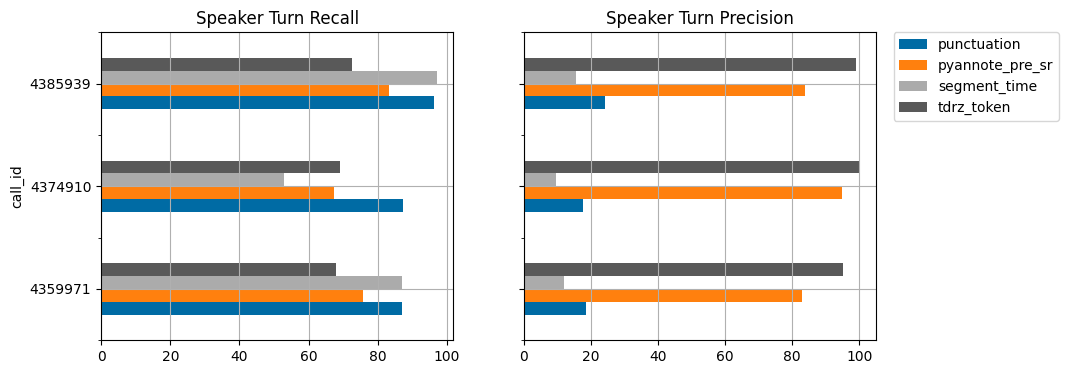

In [46]:
# comparing results for pyannote_pre_sr, time_segment, punctuation, token
subset_df = results_df.query('~(model=="small.en-ft" and method != "tdrz_token")')
subset_df = subset_df.query('method in ["punctuation", "pyannote_pre_sr", "segment_time", "tdrz_token"]')
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
d1 = query_metric_results(subset_df, "spk_turn_recall", groups=["call_id", "method"])
plot_metric_results(d1, title="Speaker Turn Recall", ax=axes[0], legend=False)
d2 = query_metric_results(subset_df, "spk_turn_precision", groups=["call_id", "method"])
plot_metric_results(d2, title="Speaker Turn Precision", ax=axes[1])

We can make the following observations:
1. The simple `punctuation` baseline has a very high recall i.e. the model is already marking speaker turns with ending punctuations. This validates our hypothesis that the model already has a good internal representation of speaker turns.
2. The `pyannote_pre_sr` pipeline has the best overall performance, although it actually has a lower recall than the simple `punctuation` baseline. We look at the errors in the next section to understand why. In summary, this is due to a weakness of independent diarization pipelines at handling short segments.
3. The `segment_time` baseline somewhat matches `punctuation` but is a bit erratic. Inconsistent behavior of whisper timestamps is a known issue, and thus punctuations are a better choice for a baseline.
4. The `tdrz_token` approach significantly improves precision over the `punctuation` baseline to a consistent near-perfect accuracy on all meetings. This confirms that finetuning is effective at isolating this behavior that was already present in the model. There is still some gap in recall, which is likely fixable with improving the toy finetuning setup.

Thus, much like punctuations, speaker turns have both acoustic and semantic cues and it is not suprising to see that Whisper already has a strong prior to do quite well at this task.

Note that our goal here is not necessarily to beat state of the art, but via this proof-of-concept, to show that we can get strong performance with a much simpler and efficient design. Unlike dedicated diarization pipelines, `tdrz_token` has no extra cost at inference time as it runs as part of `whisper.transcribe`. 

## Error inspection

We now manually look through some examples to build intuition about what's going on and where bottlenecks lie.

In [ ]:
# listen to an example file
ipd.Audio(f'{WORKDIR}/audio/earnings21-4385939.mp3')

### Recall Errors (*939, *910): pyannote_pre_sr

Errors from the pyannote pipeline tend to be around short, few-word segments. From looking through examples, these are mostly backchannel responses that can occasionally involve partially overlapped speech. The errors are of two kinds - 
- ASR errors: Whisper tends to skip over words, which may be exacerbated by transcribing pre-segmented segments from the output of pyannote. Some recent implementations run whisper as-is on long audio and attempt to reconcile diarization results using timestamps. However this can get gnarly as it has to handle overlaps, missed words and other edge cases.

- Pyannote under-segmentation errors: Due to design limitations discussed in the blog post, pipelines like pyannote have to trade-off temporal resolution with accuracy. This is clearly reflected in the errors we see below, where short segments were likely merged into longer ones either during segmentation or clustering.

In [10]:
# 0,3,4,6,7,9,10,11,13,14  - ASR DEL errors; 
# 1,2,5,8,12,15  - valid under-segmentation/recall errors;
inspect_errors(results_df, analysis_results, ("small.en", "4385939", "pyannote_pre_sr"), recall_errors=[1,5,8])

Results for: ('small.en', '4385939', 'pyannote_pre_sr')


,metric,value,denominator,numerator,deletions,insertions,substitutions
0,wer_overall,14.317279,9052,1296,606,174,516
1,wer_speaker_switch,24.849699,998,248,69,63,116
2,spk_turn_precision,83.846153,130,109,0,18,3
3,spk_turn_recall,83.206108,131,109,16,0,6


Precision errors: 21
Recall errors: 16


 ---------- Recall errors: ----------

Line: 738
                that	that                			
       speaker__turn	speaker__turn       		___7_SPEAKER_TURN___	###7_###|
               great	great               			
               great	<del>               	ERR		
              thanks	thanks              			
                very	very                			
                much	much                			
       speaker__turn	speaker__turn       		___8_SPEAKER_TURN___	###8_###|
               thank	thank               			
                 you	you                 			
       speaker__turn	<del>               	ERR	___9_SPEAKER_TURN___	###9_###|
               thank	thank               			
                 you	you                 			
                 our	our                 			
                next	next                			
            question	question            			
               comes	comes               			
                from	from                			
       

In [11]:
# 0,1 - invalid laughter;
# 2,3,4,5,6,11,12 - ASR DEL errors;
# 7,8,9,10,13,14,15,16 - valid under-segmentation/recall errors;
inspect_errors(results_df, analysis_results, ("small.en", "4374910", "pyannote_pre_sr"), recall_errors=[7,9,13])

Results for: ('small.en', '4374910', 'pyannote_pre_sr')


,metric,value,denominator,numerator,deletions,insertions,substitutions
0,wer_overall,13.713123,4915,674,360,71,243
1,wer_speaker_switch,21.914893,470,103,48,21,34
2,spk_turn_precision,94.871796,39,37,0,1,1
3,spk_turn_recall,67.272728,55,37,17,0,1


Precision errors: 2
Recall errors: 17


 ---------- Recall errors: ----------

Line: 3306
             believe	believe             			
        historically	historically        			
                 was	was                 			
               about	about               			
                half	half                			
                that	that                			
                  of	of                  			
                 the	the                 			
               spend	spend               			
               share	share               			
       speaker__turn	<del>               	ERR	___34_SPEAKER_TURN___	###34_###|
                 yes	yes                 			
       speaker__turn	<del>               	ERR	___35_SPEAKER_TURN___	###35_###|
                  so	so                  			
                  if	if                  			
                 you	you                 			
                 can	can                 			
                 dig	dig                 			
                into	into       

### Recall Errors (*910): tdrz_token

Meanwhile, we see that the punctuation baseline has a much higher recall. All the remaining errors are actually ASR errors, where whisper skipped over some backchannel words. 

This means that (for the words recognized by whisper) the model is already able to distinguish different speakers by placing punctuations at the right places. As we can see from the examples so far, the speaker turns have a clear acoustic and semantic signal that the model is able to pick up on. 

Semantics is particularly important for backchannel responses, which are often short and have little acoustic signal, and are something traditional pipelines like pyannote struggle with.

In [22]:
# notes on recall errors:
# 0,1,2,3 - ASR deleted backchannel;
inspect_errors(results_df, analysis_results, ("small.en", "4374910", "punctuation"), recall_errors=[0,2,3])

Results for: ('small.en', '4374910', 'punctuation')


,metric,value,denominator,numerator,deletions,insertions,substitutions
0,wer_overall,10.140216,4921,499,325,38,136
1,wer_speaker_switch,17.659575,470,83,54,6,23
2,spk_turn_precision,17.712177,271,48,0,156,67
3,spk_turn_recall,87.272728,55,48,4,0,3


Precision errors: 223
Recall errors: 4


 ---------- Recall errors: ----------

Line: 1424
                 had	had                 			
                  an	an                  			
                   e	e                   		___100010_SYN_1-2___	
            commerce	commerce            		___100010_SYN_1-2___	
         transaction	transaction         			
                  on	on                  			
                amex	amex                			
              before	before              			
       speaker__turn	speaker__turn       		___15_SPEAKER_TURN___	###15_###|
                 wow	<del>               	ERR		
       speaker__turn	<del>               	ERR	___16_SPEAKER_TURN___	###16_###|
                  um	<del>               	ERR		
                  so	so                  			
               there	there               			
               we've	we've               			
                seen	seen                			
                some	some                			
                real	real        

### Precision errors (*939): pyannote_pre_sr

Here too we see errors involving oversegmentation of short segments. Either falsely assigning a short segment to a new speaker, or falsely creating overlapped segments.

`TODO@Akash` - go through this more closely

In [26]:
# notes on precision errors:
# 0 - pyannote false positive short segment, not transcribed;
# 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19 - oversegmentation of short segments;
# 20 - duplicated overlapped section
inspect_errors(results_df, analysis_results, ("small.en", "4385939", "pyannote_pre_sr"), precision_errors=[4,6,8])

Results for: ('small.en', '4385939', 'pyannote_pre_sr')


,metric,value,denominator,numerator,deletions,insertions,substitutions
0,wer_overall,14.317279,9052,1296,606,174,516
1,wer_speaker_switch,24.849699,998,248,69,63,116
2,spk_turn_precision,83.846153,130,109,0,18,3
3,spk_turn_recall,83.206108,131,109,16,0,6


Precision errors: 21
Recall errors: 16


 ---------- Precision errors: ----------

Line: 4049
     congratulations	congratulations     			
                  on	on                  			
                   a	<del>               	ERR		
               great	great               			
           execution	execution           			
                  in	in                  			
                 the	the                 			
             quarter	quarter             			
       speaker__turn	speaker__turn       		___55_SPEAKER_TURN___	###55_###|
               <ins>	great               	ERR		
               <ins>	speaker__turn       	ERR		
              thanks	thanks              			
               david	<del>               	ERR		
       speaker__turn	speaker__turn       		___56_SPEAKER_TURN___	###56_###|
               <ins>	savings             	ERR		
                   i	i                   			
                 had	had                 			
               <ins>	to                  	ERR		
                

### Precision errors (*939): tdrz_token

We see that the finetuned model makes virtually no errors. This is a good sign, showing that even with a relatively toy finetuning setup, the model has a strong prior to place speaker turns at the right places.

In [30]:
inspect_errors(results_df, analysis_results, ("small.en-ft", "4385939", "token"), precision_errors=[0])

Results for: ('small.en-ft', '4385939', 'token')


,metric,value,denominator,numerator,deletions,insertions,substitutions
0,wer_overall,7.498897,9068,680,83,228,369
1,wer_speaker_switch,11.422846,998,114,27,31,56
2,spk_turn_precision,98.958328,96,95,0,1,0
3,spk_turn_recall,72.519081,131,95,30,0,6


Precision errors: 1
Recall errors: 30


 ---------- Precision errors: ----------

Line: 6317
               piper	piper               			
             sandler	sandler             			
              please	please              			
             proceed	proceed             			
                with	with                			
                your	your                			
            question	questions           	ERR		
       speaker__turn	speaker__turn       		___76_SPEAKER_TURN___	###76_###|
               <ins>	come                	ERR		
               <ins>	on                  	ERR		
               <ins>	speaker__turn       	ERR		
               thank	thank               			
                 you	you                 			
                good	good                			
             morning	morning             			
       speaker__turn	speaker__turn       		___77_SPEAKER_TURN___	###77_###|
                good	good                			
             morning	morning             			
       speaker__turn	sp

The model already separates different speakers using punctuations very reliably, with high recall. 

This confirms the hypothesis that time resolution is clearly a limitation of indepedent pre-sr pipelines.

# Misc discussion

- comparison of WER from pre_sr segmentation and after finetuning
- comparison of runtime between pyannote, tinydiarize and time_segment_clustered
- discussion of integration with clustering via post_sr results

### WER comparison and impact of fine-tuning

We can see that naively altering the segments in `drz_pre_sr` can have a significant (15%+ relative) negative impact on the WER. In regions around speaker switches the impact is much higher (40-70%), as segments tend to be much shorter here.

In [ ]:
subset_df = results_df.query('method in ["pyannote_pre_sr", "time_segment"]')
print("WER impact of finetuning")
ipd.display(query_metric_results(subset_df.query('method=="time_segment"'), "wer_overall", groups=["call_id", "model"]))
# we see that after finetuning, the overall WER not impacted too much
print("WER impact of segmentation in pyannote_pre_sr")
ipd.display(query_metric_results(subset_df, "wer_overall", groups=["call_id", "method"]))
# ipd.display(query_metric_results(subset_df, "wer_speaker_switch", groups=["call_id", "method"]))
# pre-segmented recognition hurts WER, especially around speaker switches

WER impact of finetuning


model,small.en,small.en-ft
call_id,,
4359971,13.03,13.89
4374910,10.14,6.91
4385939,10.18,7.50


WER impact of segmentation in pyannote_pre_sr


method,pyannote_pre_sr,time_segment
call_id,,
4359971,19.58,13.03
4374910,13.71,6.91
4385939,14.32,7.50


I've also noticed these undesirable regressions/gotchas. The regressions are fixable with more modular and careful finetuning.
- the finetuned model spkturn_segments has significantly lower recall from ~ 80% -> 10%. probably because of training on a different (longer) distribution of segments in ami data. or that the model simply forgets to output timestamps
- WER is quite different, some better or worse, with very different sub/ins/del pattern

### Runtime comparison

### Discussion on adding clustering

`TODO@Akash` - clean up rough notes here and complete end section

how to retain advantages?

looking closer we see why (insert nemo graphic on fidelity vs temporal resolution). this tradeoff comes at a significant extra cost (already quite expensive). even so, it is a patch on a fundamental drawback. SR models can easiliy output tokens at much higher time resolution, making it a much more natural choice. 
this will only yield local (within 30s chunk) - will still need a clustering process to group speakers across full timescale of meeting.

- gap in recall between drz_post_sr and segment            (indicates ?)
- gap in precision errors for post sr on 9971 inspite of higher recall?  (indicates clustering errors)

overall, the gap between segment and drz_post_sr shows a lot of clustering errors. 

Summary:
- the model makes very few spk turn predictions but with ~100% precision. these are likely already included within punctuations (should check if these were missed by time segments, or diarization)
- `drz_post_sr` clustering will still be needed. hope is that `speaker_turn` is predicted well difficult parts (short segments) acting in a complementary way to further improve clustering recall errors. to enable `drz_post_sr`, i need to modify decoding to force sample a timestamp when token is predicted
- since the model tends to be very precise, another `speaker_same` token could also help clustering precision errors, so that short segments still get assigned to the same speaker when there are larger # of speakers. in this case we'd skip sampling a timestamp to make a longer segment